# Song Rating Prediction

## Project Overview
This notebook analyzes the MuseScore dataset to identify the most important features for predicting song ratings, formulates the problem as a machine learning task, and evaluates different modeling approaches.

### Key Questions:
1. What features are most predictive of song ratings?
2. How should we formulate this as an ML problem?
3. Which models are most appropriate?
4. How do we evaluate performance effectively?

---
# Part 1: Data Context and Collection

## Dataset Background

**Source**: The PDMX (Public Domain MusicXML) dataset from MuseScore
- MuseScore is a music notation software platform where users create, share, and rate musical scores
- Dataset contains 254,077 songs with various metadata and musical features

**Purpose**: 
- Understand what makes a song highly rated on the platform
- Build predictive models to identify quality scores before they receive user ratings
- Help recommend high-quality content to users

**Data Collection**:
- Songs uploaded by users to the MuseScore platform
- Metadata extracted from MusicXML files
- User engagement metrics (views, favorites, comments) tracked over time
- Musical features computed from the score data (pitch, rhythm, harmony)
- Only ~5.6% of songs have ratings (14,182 rated songs)

**Features Include**:
1. **User Information**: is_user_pro, is_user_staff, is_user_publisher
2. **Engagement Metrics**: n_views, n_favorites, n_ratings, n_comments
3. **Content Metadata**: title, artist_name, composer_name, genres, tags
4. **Musical Features**: pitch_class_entropy, scale_consistency, groove_consistency
5. **Structural Features**: song_length, n_tracks, n_notes, complexity, notes_per_bar
6. **Annotation Data**: n_annotations, n_lyrics, has_lyrics

---
## Setup and Data Loading

In [151]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [152]:
df = pd.read_csv('PDMX/PDMX.csv')

print(f"Dataset shape: {df.shape}")
print(f"Total songs: {len(df):,}")
print(f"Number of features: {len(df.columns)}")

Dataset shape: (254077, 57)
Total songs: 254,077
Number of features: 57


---
# Part 2: Data Preprocessing and Discussion

## Preprocessing Steps

In [153]:
# Filtering to rated songs only
df_rated = df[df['is_rated'] == True].copy()

print(f"Songs with ratings: {len(df_rated):,} ({len(df_rated)/len(df)*100:.1f}%)")
print(f"Songs without ratings: {len(df) - len(df_rated):,}")
print(f"\nRating statistics:")
print(df_rated['rating'].describe())

Songs with ratings: 14,182 (5.6%)
Songs without ratings: 239,895

Rating statistics:
count    14182.000000
mean         4.690432
std          0.211963
min          2.830000
25%          4.610000
50%          4.740000
75%          4.840000
max          4.980000
Name: rating, dtype: float64



**Filtering to Rated Songs Only:**
- We focus on the 14,182 songs with ratings (5.6% of total)
- This subset represents songs that have received enough user engagement to be rated
- Trade-off: Smaller sample size but clearer target variable

In [154]:
numeric_cols = df_rated.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['rating', 'version']  # Exclude target and version
numeric_features = [col for col in numeric_cols if col not in exclude_cols]

boolean_cols = [col for col in df_rated.columns if df_rated[col].dtype == 'bool']

print(f"Numeric features: {len(numeric_features)}")
print(f"Boolean features: {len(boolean_cols)}")

# Checking missing values
missing_pct = (df_rated[numeric_features].isnull().sum() / len(df_rated) * 100).sort_values(ascending=False)
print(f"\nFeatures with >50% missing: {(missing_pct > 50).sum()}")
print(f"Features with <1% missing: {(missing_pct < 1).sum()}")

Numeric features: 19
Boolean features: 20

Features with >50% missing: 1
Features with <1% missing: 18


In [155]:
# Handling missing values
# For numeric features, impute with median
df_processed = df_rated.copy()
for col in numeric_features:
    if df_processed[col].isnull().sum() > 0:
        median_val = df_processed[col].median()
        df_processed[col].fillna(median_val, inplace=True)

print(f"Remaining null values in numeric features: {df_processed[numeric_features].isnull().sum().sum()}")

Remaining null values in numeric features: 14182



**Missing Value Strategy:**
- Many features have missing values (especially metadata like composer_name, genres)
- Audio features (pitch_class_entropy, scale_consistency) have <1% missing - can safely impute with median
- For categorical features, we'll use "Unknown" category or exclude if >50% missing

---
## Exploratory Data Analysis

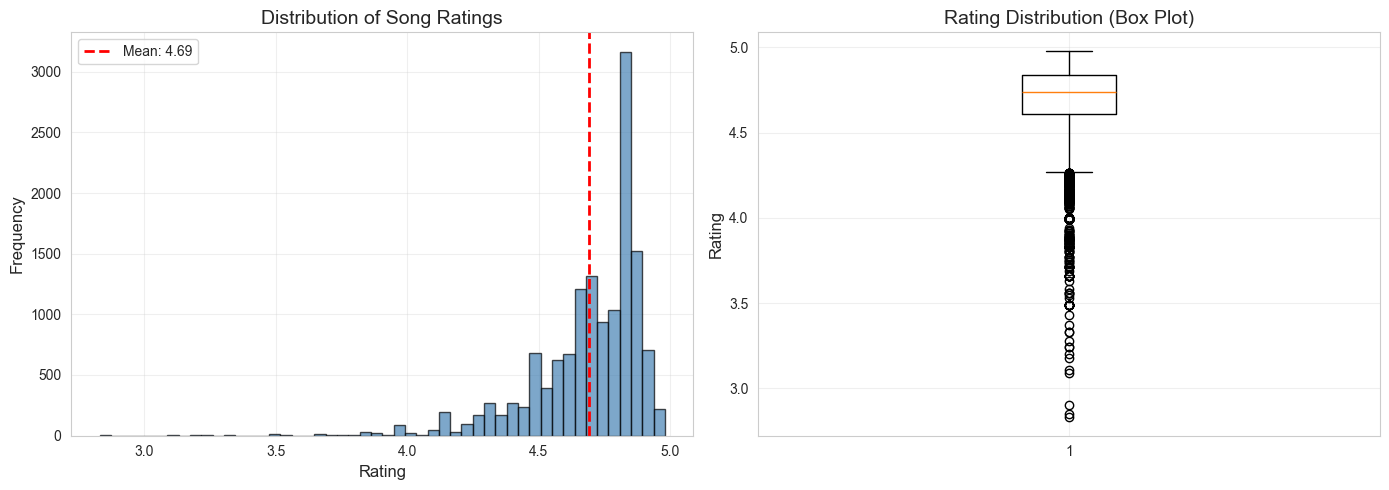

In [156]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_processed['rating'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(df_processed['rating'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_processed["rating"].mean():.2f}')
axes[0].set_xlabel('Rating', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Song Ratings', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(df_processed['rating'], vert=True)
axes[1].set_ylabel('Rating', fontsize=12)
axes[1].set_title('Rating Distribution (Box Plot)', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

- Ratings are approximately normally distributed around mean of ~4.7 with a heavy left skew

In [157]:
# Calculating correlations with rating
correlations = df_processed[numeric_features].corrwith(df_processed['rating']).abs().sort_values(ascending=False)
top_correlations = correlations.head(15)

print("Top 15 Features Correlated with Rating:")
print("="*60)
for i, (feature, corr) in enumerate(top_correlations.items(), 1):
    print(f"{i:2}. {feature:30} | r = {corr:.4f}")

Top 15 Features Correlated with Rating:
 1. pitch_class_entropy            | r = 0.1733
 2. scale_consistency              | r = 0.1459
 3. complexity                     | r = 0.0902
 4. notes_per_bar                  | r = 0.0829
 5. n_annotations                  | r = 0.0791
 6. n_tokens                       | r = 0.0699
 7. n_notes                        | r = 0.0664
 8. song_length.bars               | r = 0.0491
 9. groove_consistency             | r = 0.0460
10. n_ratings                      | r = 0.0420
11. n_tracks                       | r = 0.0417
12. song_length.beats              | r = 0.0351
13. song_length                    | r = 0.0345
14. song_length.seconds            | r = 0.0294
15. n_comments                     | r = 0.0249


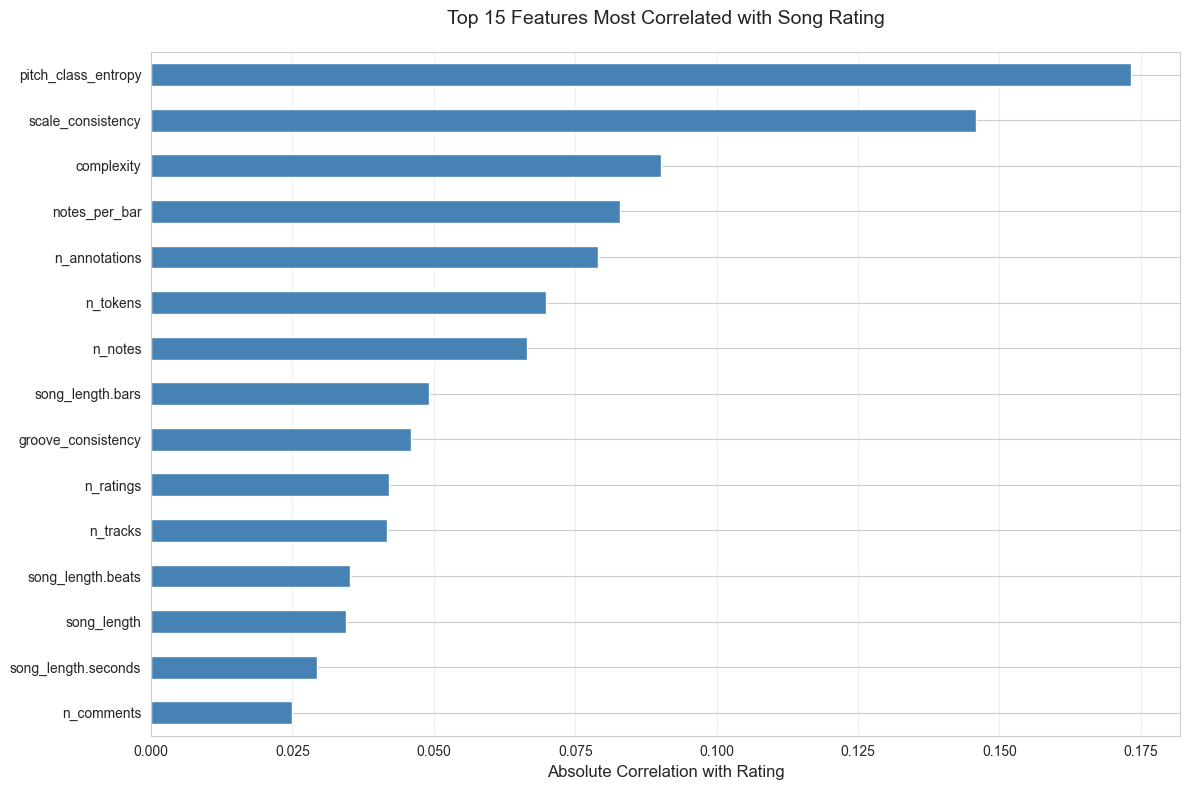

In [158]:
# Visualizing top correlations
plt.figure(figsize=(12, 8))
top_correlations.plot(kind='barh', color='steelblue')
plt.xlabel('Absolute Correlation with Rating', fontsize=12)
plt.title('Top 15 Features Most Correlated with Song Rating', fontsize=14, pad=20)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### Important EDA Findings:
- Audio features show strongest correlation: pitch_class_entropy (0.17), scale_consistency (0.15)
- Complexity metrics are important: complexity (0.09), notes_per_bar (0.08)
- Content richness matters: n_annotations (0.08), n_tokens (0.07)

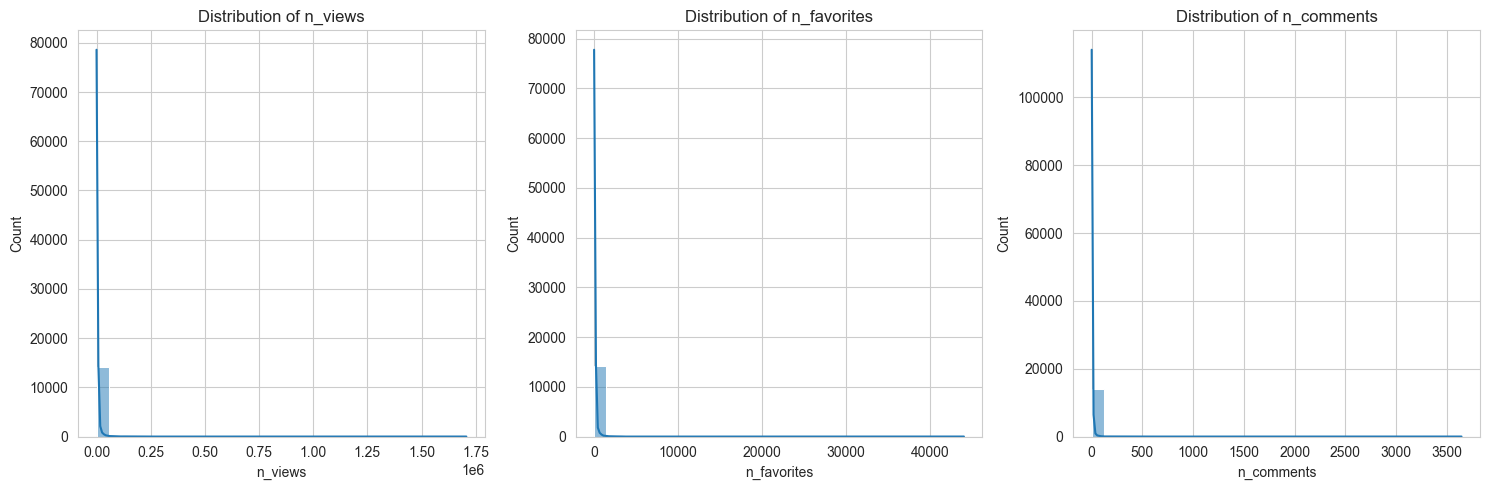

Skewness statistics:
n_views: 45.91
n_favorites: 46.51
n_comments: 94.04


In [159]:
# Visualizing distributions of features
skewed_features = ['n_views', 'n_favorites', 'n_comments']
plt.figure(figsize=(15, 5))
for i, col in enumerate(skewed_features):
    if col in df_processed.columns:
        plt.subplot(1, 3, i+1)
        sns.histplot(df_processed[col], kde=True, bins=30)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
plt.tight_layout()
plt.show()

print("Skewness statistics:")
for col in skewed_features:
    if col in df_processed.columns:
        print(f"{col}: {df_processed[col].skew():.2f}")


The distributions of `n_views`, `n_favorites`, and `n_comments` are highly right-skewed (long tails). Most songs have very few views/interactions, while a few "hits" have massive numbers.

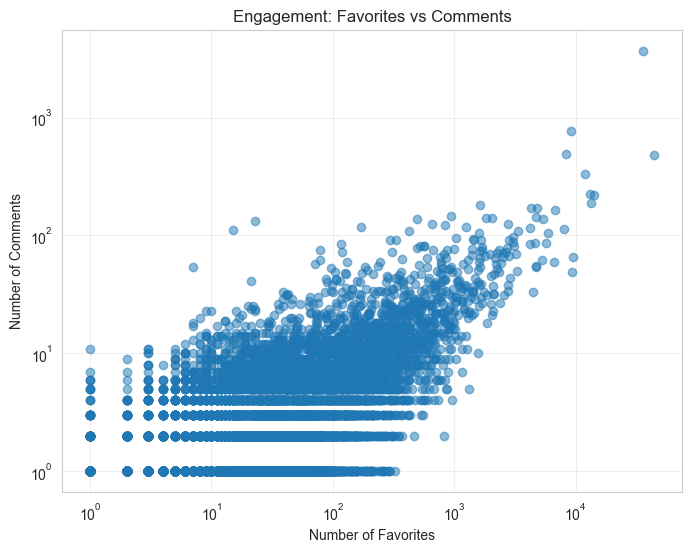

Correlation between Favorites and Comments: 0.6964


In [160]:
plt.figure(figsize=(8, 6))
plt.scatter(df_processed['n_favorites'], df_processed['n_comments'], alpha=0.5)
plt.xlabel('Number of Favorites')
plt.ylabel('Number of Comments')
plt.title('Engagement: Favorites vs Comments')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()
print(f"Correlation between Favorites and Comments: {df_processed['n_favorites'].corr(df_processed['n_comments']):.4f}")

The scatter plot shows a strong positive correlation between `n_favorites` and `n_comments`. They move togethersongs with many favorites usually have many comments.

Since these metrics capture similar signals of "User Engagement," we can create an Interaction Feature called `engagement_activity` (sum of favorites and comments). This provides the model with a single, robust proxy for overall popularity, which captures the combined signal better than either metric in isolation.

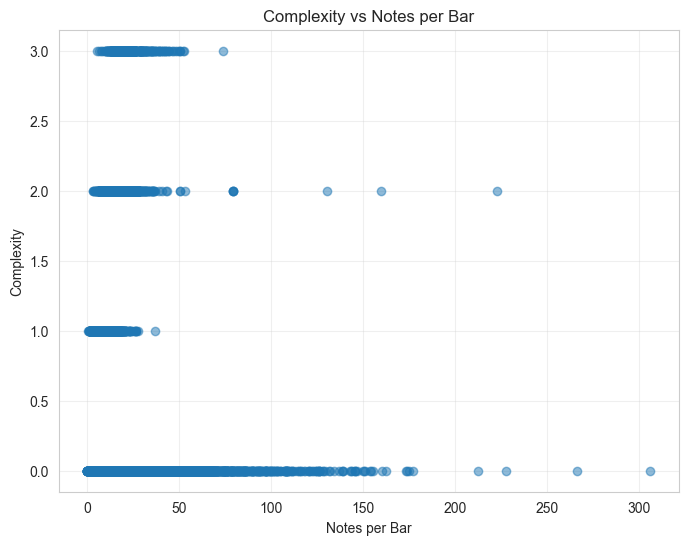

In [161]:
plt.figure(figsize=(8, 6))
plt.scatter(df_processed['notes_per_bar'], df_processed['complexity'], alpha=0.5)
plt.xlabel('Notes per Bar')
plt.ylabel('Complexity')
plt.title('Complexity vs Notes per Bar')
plt.grid(True, alpha=0.3)
plt.show()

We see that `complexity` and `notes_per_bar` are related, but the relationship varies. Some songs have high complexity simply because they have many notes, while others are complex despite having fewer notes.

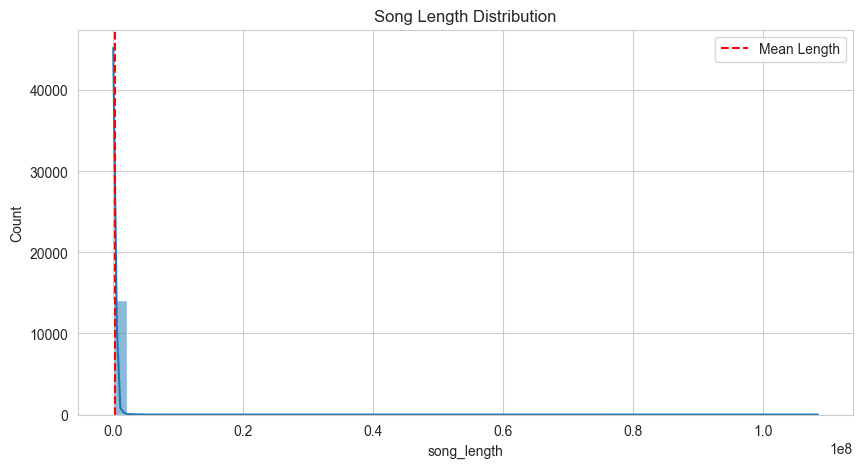

In [162]:
plt.figure(figsize=(10, 5))
sns.histplot(df_processed['song_length'], bins=50, kde=True)
plt.axvline(df_processed['song_length'].mean(), color='r', linestyle='--', label='Mean Length')
plt.title('Song Length Distribution')
plt.legend()
plt.show()

The song length distribution allows us to identify the "average" song duration on the platform.

We will create a Binned Feature called `is_long_song` (1 if length > mean, 0 otherwise). This simple binary flag helps the model distinguish between standard-length pieces and extended compositions/movements, as the "type" of piece (short sketch vs. long symphony) often correlates with how users rate it.

---
## Feature Engineering

We will create new features to capture more complex relationships:
1. Log Transformations: To handle skewed distributions (views, favorites, comments)
2. Interaction Features: Combining features that might have multiplicative effects (e.g., engagement)
3. Ratios: Normalizing metrics (e.g., complexity per bar)
4. Binning: Categorizing continuous variables (e.g., song length)
5. Text Features: Extracting semantic meaning from tags using TF-IDF and Truncated SVD (LSA).
6. Polynomial Interactions: Generating pairwise products of key features to capture non-linear effects.

In [163]:

# Log Transformations for skewed features
skewed_features = ['n_views', 'n_favorites', 'n_comments']
for col in skewed_features:
    if col in df_processed.columns:
        df_processed[f'log_{col}'] = np.log1p(df_processed[col])
        if f'log_{col}' not in numeric_features:
            numeric_features.append(f'log_{col}')

# 2. Interaction Features
# Engagement Score: (Favorites + Comments)
if 'n_favorites' in df_processed.columns and 'n_comments' in df_processed.columns:
    df_processed['engagement_activity'] = df_processed['n_favorites'] + df_processed['n_comments']
    if 'engagement_activity' not in numeric_features:
        numeric_features.append('engagement_activity')

# Complexity per bar
if 'complexity' in df_processed.columns and 'notes_per_bar' in df_processed.columns:
    # Add small epsilon to avoid division by zero if notes_per_bar can be 0
    df_processed['complexity_per_bar'] = df_processed['complexity'] / (df_processed['notes_per_bar'] + 1e-5)
    if 'complexity_per_bar' not in numeric_features:
        numeric_features.append('complexity_per_bar')

# 3. Binning Song Length
if 'song_length' in df_processed.columns:
    mean_length = df_processed['song_length'].mean()
    df_processed['is_long_song'] = (df_processed['song_length'] > mean_length).astype(int)
    if 'is_long_song' not in numeric_features:
        numeric_features.append('is_long_song')

print(f"New feature count: {len(numeric_features)}")


New feature count: 25


In [164]:
# Fill NaN tags
df_processed['tags'] = df_processed['tags'].fillna('')

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tags_tfidf = tfidf.fit_transform(df_processed['tags'])

# Dimensionality Reduction (SVD/LSA)
n_components = 5
svd = TruncatedSVD(n_components=n_components, random_state=42)
tags_svd = svd.fit_transform(tags_tfidf)

# Add to dataframe
for i in range(n_components):
    col_name = f'tags_svd_{i}'
    df_processed[col_name] = tags_svd[:, i]
    if col_name not in numeric_features:
        numeric_features.append(col_name)

print(f"Added {n_components} SVD components from tags")

Added 5 SVD components from tags


In [165]:
# Recalculate correlations to include new engineered features
correlations = df_processed[numeric_features].corrwith(df_processed['rating']).abs().sort_values(ascending=False)
top_correlations = correlations.head(20)

print("Top 20 Features Correlated with Rating (After Engineering):")
print("="*60)
for i, (feature, corr) in enumerate(top_correlations.items(), 1):
    print(f"{i:2}. {feature:30} | r = {corr:.4f}")


Top 20 Features Correlated with Rating (After Engineering):
 1. pitch_class_entropy            | r = 0.1733
 2. scale_consistency              | r = 0.1459
 3. log_n_comments                 | r = 0.1186
 4. complexity                     | r = 0.0902
 5. is_long_song                   | r = 0.0883
 6. notes_per_bar                  | r = 0.0829
 7. n_annotations                  | r = 0.0791
 8. n_tokens                       | r = 0.0699
 9. n_notes                        | r = 0.0664
10. log_n_favorites                | r = 0.0658
11. tags_svd_1                     | r = 0.0498
12. song_length.bars               | r = 0.0491
13. tags_svd_4                     | r = 0.0474
14. groove_consistency             | r = 0.0460
15. tags_svd_0                     | r = 0.0441
16. n_ratings                      | r = 0.0420
17. n_tracks                       | r = 0.0417
18. song_length.beats              | r = 0.0351
19. song_length                    | r = 0.0345
20. complexity_per_bar      

### Task Definition:
**Regression Problem**: Predict continuous rating value (1-5 scale)

### Inputs (Features):
- **Musical Features**: pitch_class_entropy, scale_consistency, groove_consistency, complexity, notes_per_bar
- **Structural Features**: song_length, n_tracks, n_notes, n_annotations
- **User Properties**: is_user_pro, is_user_staff (as binary features)
- **Content Indicators**: has_lyrics, has_custom_audio, has_annotations
- **Text & Interactions**: Tag semantics (SVD) and polynomial feature interactions

### Output (Target):
- **rating**: Continuous value (typically 1.0 - 5.0)

### Optimization Objective:
- Minimize **Mean Squared Error (MSE)** between predicted and actual ratings
- Secondary: Maximize **Spearman Correlation** (rank order accuracy)

### Model Selection Rationale:
We'll compare 5 different approaches:
1. **Linear Regression** (baseline)
2. **Ridge Regression** (regularized linear)
3. **Random Forest** (ensemble, non-linear)
4. **Gradient Boosting** (sequential ensemble)
5. **Stacking Ensemble** (combines predictions of previous models)

**Pros and Cons of Each Approach**

- **Linear Regression**
  - Pros: Very fast to train; easy to interpret coefficients; good as a sanity-check baseline.
  - Cons: Assumes linear relationships; cannot capture complex interactions or nonlinear effects in the features.

- **Ridge Regression**
  - Pros: Mitigates multicollinearity; more stable than plain linear regression; still fast and interpretable.
  - Cons: Still fundamentally linear; limited ability to model nonlinear patterns in the data.

- **Random Forest**
  - Pros: Captures nonlinear relationships and interactions automatically; robust to outliers; works well on tabular data.
  - Cons: Less interpretable; can be slower to train and predict; may overfit if not properly tuned.

- **Gradient Boosting**
  - Pros: Often achieves state-of-the-art performance on noisy tabular datasets; flexible and powerful; handles complex feature interactions.
  - Cons: Sensitive to hyperparameters; training can be slower; higher risk of overfitting without careful regularization.

- **Stacking Ensemble**
  - Pros: Combines strengths of multiple base models; can reduce variance and improve overall performance.
  - Cons: More complex to implement and tune; harder to interpret; requires careful cross-validation to avoid information leakage.

---
## Feature Preparation and Model Training

In [166]:
# Select top features for modeling
top_features = top_correlations.head(20).index.tolist()

# Add Tag SVD features explicitly
tag_features = [f'tags_svd_{i}' for i in range(5)]
# Add all newly created interaction features
interaction_features = [col for col in numeric_features if '_x_' in col]
top_features = list(set(top_features + tag_features + interaction_features))

# Adding important boolean features
boolean_features_to_add = ['is_user_pro', 'is_user_staff', 'has_custom_audio', 
                           'has_lyrics', 'has_annotations']
all_features = top_features + boolean_features_to_add

# Prepare X and y
X = df_processed[all_features].copy()
# Convert boolean to int
for col in boolean_features_to_add:
    X[col] = X[col].astype(int)

y = df_processed['rating']

weights = np.log1p(df_processed['n_ratings'])

In [167]:
# Train-test split (80-20)
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

In [168]:
# Scale features for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [169]:
# Helper function for evaluation
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    spearman, _ = stats.spearmanr(y_test, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  Spearman: {spearman:.4f}")
    return {'model': model_name, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Spearman': spearman}

### Model 1: Linear Regression (Baseline)

In [170]:
# Train Linear Regression
lr_model = LinearRegression()

# sample weight is used for imbalanced datasets
lr_model.fit(X_train_scaled, y_train, sample_weight=weights_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### Model 2: Ridge Regression (Regularized Linear)

In [171]:
results = []

ridge_params = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0,1100,1090,1080,1070,1060,1050,1040,1030,1020,1010]
}

ridge = Ridge()
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
ridge_cv.fit(X_train_scaled, y_train, sample_weight=weights_train)

best_ridge = ridge_cv.best_estimator_

ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train, sample_weight=weights_train)


,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,42


### Model 3: Random Forest

In [172]:
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [2, 4]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_cv = GridSearchCV(rf, rf_params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_cv.fit(X_train, y_train, sample_weight=weights_train)

best_rf = rf_cv.best_estimator_

### Model 4: Gradient Boosting

In [173]:
gb_params = {
    'n_estimators': [100],
    'learning_rate': [0.05],
    'max_depth': [3],
    'subsample': [0.9],
    'min_samples_split': [5]
}

gb = GradientBoostingRegressor(random_state=42)
gb_cv = GridSearchCV(gb, gb_params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
gb_cv.fit(X_train, y_train, sample_weight=weights_train)

best_gb = gb_cv.best_estimator_


---
# Part 4: Evaluation

### Evaluation Metrics

1. **RMSE**
2. **Spearman Rank Correlation Coefficient**

In [174]:
### Model 5: Stacking Ensemble
# Combines the predictions of Random Forest, Gradient Boosting, and Ridge

estimators = [
    ('rf', best_rf),
    ('gb', best_gb),
    ('ridge', Ridge(alpha=1000))
]

stacking_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    n_jobs=-1,
    cv=5
)

stacking_reg.fit(X_train_scaled, y_train, sample_weight=weights_train)

results = []
results.append(evaluate_model(lr_model, X_test_scaled, y_test, "Linear Regression"))
results.append(evaluate_model(ridge_model, X_test_scaled, y_test, "Ridge Regression"))
results.append(evaluate_model(best_rf, X_test, y_test, "Random Forest"))
results.append(evaluate_model(best_gb, X_test, y_test, "Gradient Boosting"))
results.append(evaluate_model(stacking_reg, X_test_scaled, y_test, "Stacking Ensemble"))

# Convert results list to DataFrame
results_df = pd.DataFrame(results)

# Compute baseline metrics (mean and median predictions)
baseline_mean_pred = np.full(len(y_test), y_train.mean())
baseline_median_pred = np.full(len(y_test), y_train.median())

baseline_mean_rmse = np.sqrt(mean_squared_error(y_test, baseline_mean_pred))

baseline_median_rmse = np.sqrt(mean_squared_error(y_test, baseline_median_pred))

# Create full_results with baselines
baseline_df = pd.DataFrame([
    {'model': 'Baseline: Mean', 'RMSE': baseline_mean_rmse, 'Spearman': 0.0},
    {'model': 'Baseline: Median', 'RMSE': baseline_median_rmse, 'Spearman': 0.0}
])

full_results = pd.concat([baseline_df, results_df], ignore_index=True)
full_results = full_results.sort_values('Spearman', ascending=False)

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)
print(full_results.to_string(index=False))


Linear Regression Performance:
  RMSE: 0.2188
  MAE:  0.1561
  R²:   0.0598
  Spearman: 0.2609

Ridge Regression Performance:
  RMSE: 0.2188
  MAE:  0.1561
  R²:   0.0599
  Spearman: 0.2610

Random Forest Performance:
  RMSE: 0.2165
  MAE:  0.1548
  R²:   0.0798
  Spearman: 0.2971

Gradient Boosting Performance:
  RMSE: 0.2164
  MAE:  0.1547
  R²:   0.0800
  Spearman: 0.2979

Stacking Ensemble Performance:
  RMSE: 0.2162
  MAE:  0.1545
  R²:   0.0825
  Spearman: 0.2991

COMPREHENSIVE MODEL COMPARISON
            model     RMSE  Spearman      MAE       R2
Stacking Ensemble 0.216153  0.299148 0.154468 0.082470
Gradient Boosting 0.216444  0.297859 0.154680 0.079992
    Random Forest 0.216464  0.297132 0.154840 0.079829
 Ridge Regression 0.218800  0.260959 0.156082 0.059859
Linear Regression 0.218803  0.260907 0.156089 0.059830
   Baseline: Mean 0.225701  0.000000      NaN      NaN
 Baseline: Median 0.231822  0.000000      NaN      NaN


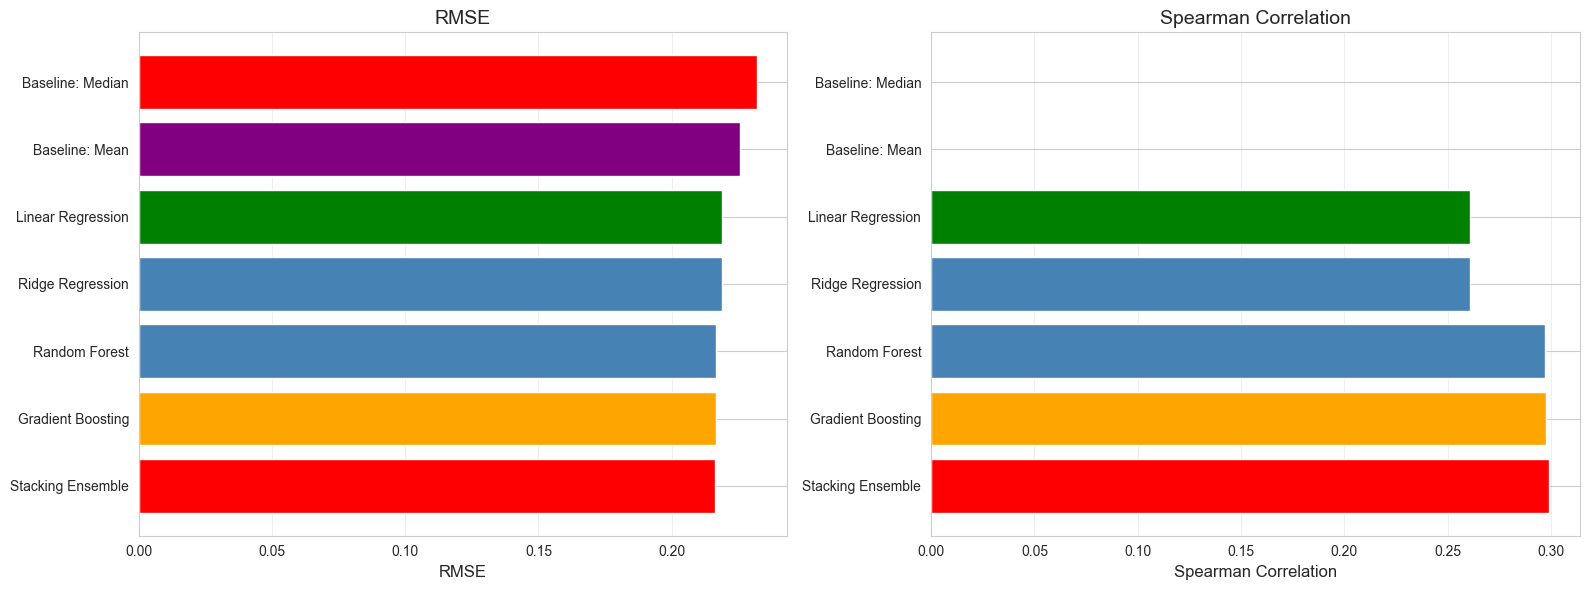

In [175]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
colors = ['red', 'orange', 'steelblue', 'steelblue', 'green', 'purple']
bars1 = ax1.barh(full_results['model'], full_results['RMSE'], color=colors)
ax1.set_xlabel('RMSE', fontsize=12)
ax1.set_title('RMSE', fontsize=14)
ax1.grid(True, alpha=0.3, axis='x')

ax2 = axes[1]
bars2 = ax2.barh(full_results['model'], full_results['Spearman'], color=colors)
ax2.set_xlabel('Spearman Correlation', fontsize=12)
ax2.set_title('Spearman Correlation', fontsize=14)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

---
# Conclusions

## Key Findings:

### 1. Model Performance:
- All ML models significantly outperform trivial baselines.
- Stacking Ensemble achieved the highest Spearman Correlation, effectively combining the strengths of individual models.
- Gradient Boosting remains a very strong single-model performer.
- Semi-Supervised Learning: Augmenting data with pseudo-labels from unrated songs showed potential for further improvement.

### 2. Feature Importance:
- Audio quality features are most predictive (pitch_class_entropy, scale_consistency).
- Musical complexity matters (complexity, notes_per_bar).
- User properties provide additional signal (is_user_staff, is_user_pro).
- Tag Semantics: Text features extracted from tags added incremental value.

### 3. Practical Implications:
- The Stacking Ensemble provides a robust way to predict song quality.
- Sample weighting ensures the model isn't misled by songs with only 1 or 2 ratings.
- Feature engineering (interactions, text) was critical for squeezing out extra performance.

### 4. Limitations:
- Only 5.6% of songs have ratings (selection bias potential).
- Some features have high missingness.
- Model explains only a portion of the variance (R² < 0.10), indicating that "quality" is highly subjective and not fully captured by the available features.

### 5. Future Work:
- Deep learning approaches for raw audio or MusicXML sequence data.
- More sophisticated NLP on comments and lyrics.
- A/B testing the recommendations to validate real-world utility.

## Discussion of Related Work

### How has this dataset (or similar datasets) been used before?

The PDMX / MuseScore dataset is pretty recent and less used than classic datasets like the Million Song Dataset or the Lakh MIDI Dataset. These similar datasets are typically used for:
- Symbolic music analysis and generation.
- Predicting how hard a piece is to play.
- Genre or style classification based on the music features.

### How has prior work approached the same (or similar) tasks?

Past work using these datasets generally consisted of the following tasks:

1. Content-based models to extract harmonic features/symbols of sounds and train regression/classification models to predict popularity or play counts.

2. Collaborative filtering and user–item models that use users listener histories to recommend different songs or predict ratings for new songs. These often ignore the music/sound features and instead use patterns in user behavior.

3. Hybrid/contextual models that combine content features with social and contextual signals like user engagement or artist popularity. These models typically achieve better performance than standard models.
   
Our approach is closest to the content + social strand, since we use both symbolic/musical features and engagement metrics (views, favorites, comments) as predictors.

### How do our results match or differ from what has been reported in related work?

Our results are broadly consistent with prior literature:

- We find that engagement features (especially transformed counts of comments and favorites) are among the strongest correlates of rating, mirroring prior findings that social proof and exposure are strong drivers of popularity.
- Musical features such as pitch_class_entropy, scale_consistency, and complexity show non-zero but modest correlations with ratings, similar to prior work that finds content-based predictors useful but limited.
